# Sandboxing a Globally Constrained Heating Model

In [1]:
import os
import logging
import warnings
import multiprocessing
import subprocess
import random
warnings.filterwarnings('ignore')

import numpy as np
from sunpy.map import Map,GenericMap
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import matplotlib
import dask.distributed

import synthesizAR
from synthesizAR.model_ext import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

 using cli
 using CLI for selections
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/ChiantiPy/tools/data.py", line 22, in <module>
    xuvtop = os.environ['XUVTOP']
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/os.py", line 725, in __getitem__
    raise KeyError(key) from None
KeyError: 'XUVTOP'



## Theory

Previously, we have constrained our heating model such that the total energy dumped into each strand is given by,

$$
\frac{(\epsilon\bar{B}_s)^2}{8\pi}
$$

where $\bar{B}_s$ is the average field strength on loop $s$. 

However, this is inconsistent with our reconnection nanoflare model. In this model, we claim that field lines are continually stressed by photospheric motion at the loop footpoints. This constant shuffling leads to the field lines being tangled and braided, i.e. stressed. This in turn gives way to the field having some non-potential component $\epsilon B_s$. This stress cannot build up infinitely and so must periodically relax, through reconnection, leading to heat being dissipated into the loop plasma. Following each relaxation, the field starts to become stressed again, with the stressed component of the field being replenished after each relaxation.

We let the amount of energy released in each relaxation be determined by a power-law with slope $\alpha$ and bounds $(E_0,E_1)$. Previously, we constrained the total energy in the power-law to be $\epsilon B_s$. However, it is more appropriate to interpret $\epsilon B_s$ as the *maximum* amount of energy that can be released in a single event, i.e. the upper limit on the power-law distribution, $E_1$. The lower-limit will remain variable and we will discuss it shortly.

How then should the total energy input be constrained? We must put some sort of limit on how much energy we are dumping into the system so as to enable meaningful comparisons between our various heating models. We do this by constraining the total flux over the whole AR, $F_{AR}$ such that,

$$
F_{AR} = \frac{\sum_s\sum_iE_{i,s}L_sA_s}{t_{total}A_{AR}},\quad [\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}]
$$

where $E_{i,s}$ [erg cm$^{-3}$] is the energy (density) of event $i$ on loop $s$ as determined by a power-law distribution, $L_s$ [cm] is the full loop length of loop $s$, $A_s$ [cm$^2$] is the estimated cross-sectional area of loop $s$, $t_{total}$ is the total simulation time, and $A_{AR}=\sum_sA_s$. A typical lower bound on $F_{AR}$ is $10^7$ erg cm$^{-2}$ s$^{-1}$ from Withbroe and Noyes (1977) and represents the flux due to radiative losses from an AR. Thus, we may choose this value to be a bit higher as this should account for the total amount of energy injected into our system.

The next problem then is how to actually go about ensuring we have injected the proper amount of energy into our system. We can formulate our problem in terms of the quantity $\phi$ such that,

$$
\phi = \frac{\sum_s\sum_iE_{i,s}L_sA_s}{t_{total}A_{AR}F_{AR}}
$$

should be as close to 1 as possible. Thus, we want to minimize the error term,

$$
\mathrm{error} = \left|1 - \frac{1}{\phi}\right|
$$

We will take an iterative approach by adjusting $E_{0,s}$, the lower bound on the power-law distribution. Note that,

$$
\phi\,\,
\begin{cases} 
< 1, & \text{need more energy} \\
> 1, & \text{need less energy} 
\end{cases}
$$

Since we want to vary the lower bound on our distribution, we want to decrease the lower bound (to permit more lower energy events and lower the total energy for a fixed number of events) when we need less energy and increase the lower bound (forcing more high energy events) when we need more energy. Thus, the correction to $E_0$ (dropping the $s$ label for now) becomes,

$$
E_0^{n+1} = E_0^n + (1 - \phi)E_0^n
$$

However, we do not want to apply this correction uniformly to all strands as some strands will contribute much more to the total flux than others. Longer strands tend to be rooted in weaker field and have longer cooling times (and thus fewer events per strand) than shorter strands closer to the core. Thus, in addition to the global correction $\phi$, we introduce a local scaling $\gamma_s$ such that,

$$
\gamma_s = \frac{L_s\sum_iE_{i,s}}{F_{AR}t_{total}/N}
$$

where $N$ is the total number of loops. Note that $F_{AR}t_{total}/N$ is the average flux per loop integrated over the simulation period. Thus,

$$
\gamma_s\,\,
\begin{cases}
< 1, & \text{lower energy (long) loops below the average flux} \\
> 1, & \text{higher energy (short) loops above the average flux}
\end{cases}
$$

Modifying the above correction factor,

$$
E_0^{n+1} = E_0^n + \gamma_s(1 - \phi)E_0^n
$$

In this way, we weight the magnitude of the correction depending on how much a given loop is contributing to the total flux. We need to make one final correction because it is required that $E_0<E_1$. More strictly, we can say that $E_0\leq\delta E_1$, where $\delta<1$. Thus, the final form of our update rule to $E_0$ becomes,

$$
E_0^{n+1} = \min{(E_0^n + \gamma_s(1 - \phi)E_0^n,\delta E_1)}
$$

Provided that $(\sum_sM_sE_{1,s}L_sA_s)/A_{AR}>t_{total}F_{AR}$, this condition should be able to be satisfied.

## Functions and Constants

First set some constants.

In [ ]:
stress_level = 0.1
freq_param = 0.1
total_time = 3e4
ar_flux_total = 1e7
alpha = -2.5

In [ ]:
def strand_energy(loop):
    return ((stress_level*loop.field_strength.value.max())**2)/8./np.pi

In [ ]:
def power_law(a0,a1,alpha,x):
    return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))

In [ ]:
def cooling_time(loop,strand_energy,duration):
    half_length = loop.full_length.value/2.
    average_heating_rate_max = strand_energy/(duration/2.)#*u.erg/(u.cm**3)/u.s
    # set some constants
    alpha = -0.5
    chi = 6e-20#*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
    kappa_0 = 1e-6#*(u.erg/u.cm/u.s*(u.K**(-7/2)))
    c1,c2,c3 = 2.0,0.9,0.6
    gamma = 5./3.
    # estimate max n0T0
    T0 = c2*(7.*half_length**2*average_heating_rate_max/2./kappa_0)**(2./7.)
    top_term = average_heating_rate_max - 2.*kappa_0*(T0**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
    bottom_term = c1*chi*(T0**alpha)*(1. - c2/c3/gamma)
    n0 = np.sqrt(top_term/bottom_term)
    n0T0 = n0*T0
    # Cargill cooling expression
    term1 = (2. - alpha)/(1. - alpha)
    term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
    term3 = ((half_length)**(8. - 4.*alpha))/(n0T0**(3+2.*alpha))
    return term1*3.*const.k_B.cgs.value*(1/term2*term3)**(1/(11. - 2.*alpha))

## Estimating Cross Sections

In [2]:
field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-09-27 19:04:05,765 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-09-27 19:04:05,765 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-09-27 19:04:05,766 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-09-27 19:04:05,767 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-09-27 19:04:05,768 Parameters: cosmological_simulation   = 0.0


In [3]:
footpoints = np.array([loop.coordinates[0,:2].value for loop in field.loops])
footpoint_dist,bin_edges = np.histogramdd(
    footpoints,
    bins = (field.clipped_hmi_map.dimensions.x.value,field.clipped_hmi_map.dimensions.y.value),
    range = (field._convert_angle_to_length(field.clipped_hmi_map.xrange).value,
             field._convert_angle_to_length(field.clipped_hmi_map.yrange).value)
)

In [4]:
area_per_pixel = (field._convert_angle_to_length(field.clipped_hmi_map.scale.x*1*u.pixel)
                  *field._convert_angle_to_length(field.clipped_hmi_map.scale.y*1*u.pixel)).value

In [6]:
ix = np.digitize(footpoints[:,0],bin_edges[0]) - 1
iy = np.digitize(footpoints[:,1],bin_edges[1]) - 1

In [7]:
loop_cross_sections = (area_per_pixel/footpoint_dist)[ix,iy]

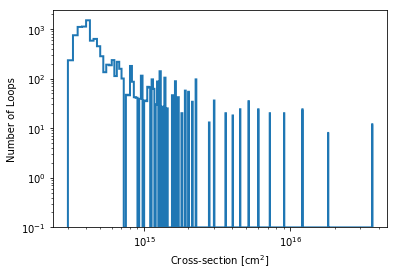

In [16]:
plt.hist(loop_cross_sections,bins='auto',histtype='step',lw=2,log=True);
plt.xscale('log')
plt.xlabel(r'Cross-section [cm$^2$]')
plt.ylabel(r'Number of Loops')

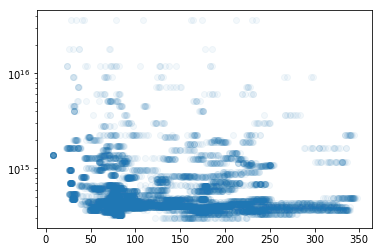

In [28]:
plt.scatter(np.array([loop.field_strength.mean().value for loop in field.loops]),
            loop_cross_sections,alpha=0.05)
#plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e14,2e15])

## Algorithm